# **TASK 4**
- Implement Bayesian Linear Regression from scratch with any appropriate sampling
method in BlackJAX.
- Create your own 1d linear dataset with added noise.
- Plot the learned predictive mean and 2 standard deviations around the mean l

# **Bayesian linear regression (BLR) using BlackJAX** 
- Bayesian linear regression is the *Bayesian* interpretation of linear regression.  
- It provides a formal and consistent way to reason in the presence of uncertainty. 
- Bayesian methods have been around for a long time and are widely-used in many areas of science (e.g. astronomy). 


- Bayesian linear regression estimates *distributions* over the parameters and predictions. This allows us to model the uncertainty in our predictions.

To perform Bayesian linear regression we follow three steps:
1. We set up a **probabilistic model** that describes our assumptions how the data and parameters are generated
2. We perform inference for the parameters $\boldsymbol{\theta}$, that is, we compute the posterior probability distribution over the parameters
3. With this posterior we can perform inference for new, unseen inputs $y_*$. In this step we don't compute point estimates of the outputs. Instead, we compute the parameters of the posterior distribution over the outputs.

### **BlackJAX** is an MCMC sampling library based on JAX. 
- BlackJAX provides well-tested and ready to use sampling algorithms. 
- It is also explicitly designed to be modular: it is easy for advanced users to mix-and-match different metrics, integrators, trajectory integrations, etc.

## **1: Probabilistic model  <a class="anchor" id="prob-model"></a>**

- We set up a probabilistic model that describes our assumptions how the data and parameters are generated. 
- For this, we place a prior $p(\boldsymbol{\theta})$ over our parameters which encodes what parameter values are plausible (before we have seen any data). 


- To keep things simple we will assume a Gaussian prior over the parameters: $p(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{m}_0, \boldsymbol{S}_0)$. 

- **Note:** When considering the set of all targets $\mathcal{Y} := \{y_1, ..., y_n \}$, the likelihood function becomes a multivariate Gaussian distribution: $p(\mathcal{Y} \mid \mathcal{X}, \boldsymbol{\theta})=\mathcal{N}\left(\boldsymbol{y} \mid \boldsymbol{\Phi} \boldsymbol{\theta}, \sigma^{2} \boldsymbol{I}\right)$



We will start our `BayesianLinearRegression` class with the knowledge we have so far - our probabilistic model. As mentioned in the beginning we assume that the variance $\sigma^2$ of the noise $\epsilon$ is known. 

In [ ]:
import jax
import jax.scipy.stats as stats
import matplotlib.pyplot as plt

import blackjax

In [ ]:
from jax.scipy.stats import multivariate_normal
import jax.numpy as np

class BayesianLinearRegression:
    """ Bayesian linear regression
    
    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
    """
    
    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float):
        self.prior_mean = prior_mean[:, np.newaxis] # column vector of shape (1, d)
        self.prior_cov = prior_cov # matrix of shape (d, d)
        # We initalize the prior distribution over the parameters using the given mean and covariance matrix
        # In the formulas above this corresponds to m_0 (prior_mean) and S_0 (prior_cov)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # We also know the variance of the noise
        self.noise_var = noise_var # single float value
        self.noise_precision = 1 / noise_var
        
        # Before performing any inference the parameter posterior equals the parameter prior
        self.param_posterior = self.prior
        # Accordingly, the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean # corresponds to m_N in formulas
        self.post_cov = self.prior_cov # corresponds to S_N in formulas
        
        
# Let's make sure that we can initialize our model
prior_mean = np.array([0, 0])
prior_cov = np.array([[0.5, 0], [0, 0.5]])
noise_var = 0.2
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

## **2.Generating a dataset  <a class="anchor" id="dataset"></a>**
- we will work with one-dimensional data and simple linear regression (that is, no non-linear transformation of the inputs). 
- Our data generating function will be of the form
$$ y = \theta_0 + \theta_1 \, x + \epsilon $$

Note that we added a parameter $\theta_0$ which corresponds to the intercept of the linear function. Until know we assumed $\theta_0 = 0$. As mentioned earlier, $\theta_1$ represents the slope of the linear function.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def compute_function_labels(slope: float, intercept: float, noise_std_dev: float, data: np.ndarray) -> np.ndarray:
    """
    Compute target values given function parameters and data.
    
    Args:
        slope: slope of the function (theta_1)
        intercept: intercept of the function (theta_0)
        data: input feature values (x)
        noise_std_dev: standard deviation of noise distribution (sigma)
        
    Returns:
        target values, either true or corrupted with noise
    """
    n_samples = len(data)
    if noise_std_dev == 0: # Real function
        return slope * data + intercept
    else: # Noise corrupted
        return slope * data + intercept + np.random.normal(0, noise_std_dev, n_samples)

In [ ]:
# Set random seed to ensure reproducibility
seed = 42
np.random.seed(seed)

# Generate true values and noise corrupted targets
n_datapoints = 1000
intercept = -0.7
slope = 0.9
noise_std_dev = 0.5
noise_var = noise_std_dev**2
lower_bound = -1.5
upper_bound = 1.5

# Generate dataset
features = np.random.uniform(lower_bound, upper_bound, n_datapoints)
labels = compute_function_labels(slope, intercept, 0., features)
noise_corrupted_labels = compute_function_labels(slope, intercept, noise_std_dev, features)

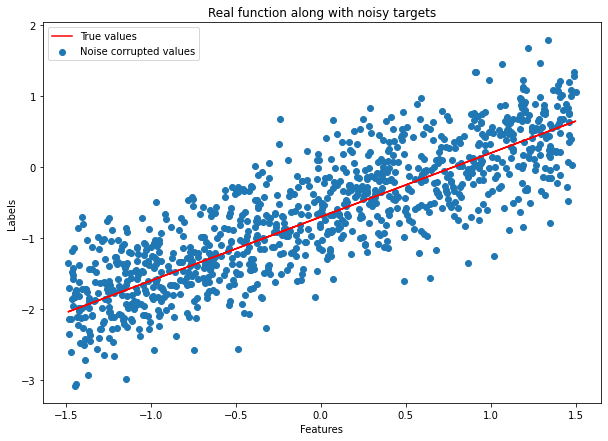

In [ ]:
# Plot the dataset
plt.figure(figsize=(10,7))
plt.plot(features, labels, color='r', label="True values")
plt.scatter(features, noise_corrupted_labels, label="Noise corrupted values")
plt.xlabel("Features")
plt.ylabel("Labels")
plt.title("Real function along with noisy targets")
plt.legend();

## **3.Posterior over the parameters  <a class="anchor" id="param-posterior"></a>**

Coming back to our `BayesLinearRegression` class we need to add a method which allows us to update the posterior distribution given a dataset.

In [ ]:
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal
import numpy as np

class BayesianLinearRegression:
    """ Bayesian linear regression
    
    Args:
        prior_mean: Mean values of the prior distribution (m_0)
        prior_cov: Covariance matrix of the prior distribution (S_0)
        noise_var: Variance of the noise distribution
    """
    
    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float):
        self.prior_mean = prior_mean[:, np.newaxis] # column vector of shape (1, d)
        self.prior_cov = prior_cov # matrix of shape (d, d)
        # We initalize the prior distribution over the parameters using the given mean and covariance matrix
        # In the formulas above this corresponds to m_0 (prior_mean) and S_0 (prior_cov)
        self.prior = multivariate_normal(prior_mean, prior_cov)
        
        # We also know the variance of the noise
        self.noise_var = noise_var # single float value
        self.noise_precision = 1 / noise_var
        
        # Before performing any inference the parameter posterior equals the parameter prior
        self.param_posterior = self.prior
        # Accordingly, the posterior mean and covariance equal the prior mean and variance
        self.post_mean = self.prior_mean # corresponds to m_N in formulas
        self.post_cov = self.prior_cov # corresponds to S_N in formulas
        
    def update_posterior(self, features: np.ndarray, targets: np.ndarray):
        """
        Update the posterior distribution given new features and targets
        
        Args:
            features: numpy array of features
            targets: numpy array of targets
        """
        # Reshape targets to allow correct matrix multiplication
        # Input shape is (N,) but we need (N, 1)
        targets = targets[:, np.newaxis]
        
        # Compute the design matrix, shape (N, 2)
        design_matrix = self.compute_design_matrix(features)

        # Update the covariance matrix, shape (2, 2)
        design_matrix_dot_product = design_matrix.T.dot(design_matrix)
        inv_prior_cov = np.linalg.inv(self.prior_cov)
        self.post_cov = np.linalg.inv(inv_prior_cov +  self.noise_precision * design_matrix_dot_product)
        
        # Update the mean, shape (2, 1)
        self.post_mean = self.post_cov.dot( 
                         inv_prior_cov.dot(self.prior_mean) + 
                         self.noise_precision * design_matrix.T.dot(targets))

        
        # Update the posterior distribution
        self.param_posterior = multivariate_normal(self.post_mean.flatten(), self.post_cov)
                
    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        """
        Compute the design matrix. To keep things simple we use simple linear
        regression and add the value phi_0 = 1 to our input data.
        
        Args:
            features: numpy array of features
        Returns:
            design_matrix: numpy array of transformed features
            
        >>> compute_design_matrix(np.array([2, 3]))
        np.array([[1., 2.], [1., 3.])
        """
        n_samples = len(features)
        phi_0 = np.ones(n_samples)
        design_matrix = np.stack((phi_0, features), axis=1)
        return design_matrix
    
 
    def predict(self, features: np.ndarray):
        """
        Compute predictive posterior given new datapoint
        
        Args:
            features: 1d numpy array of features
        Returns:
            pred_posterior: predictive posterior distribution
        """
        design_matrix = self.compute_design_matrix(features)
        
        pred_mean = design_matrix.dot(self.post_mean)
        pred_cov = design_matrix.dot(self.post_cov.dot(design_matrix.T)) + self.noise_var
        
        pred_posterior = univariate_normal(loc=pred_mean.flatten(), scale=pred_cov**0.5)
        return pred_posterior

##4. **Visualizing the parameter posterior  <a class="anchor" id="param-posterior-visualization"></a>**

- As we can see, the density is highest in the yellow regions decreasing when moving further out into the green and blue parts. 
- This should give you a better understanding of contour plots.

- To analyze our Bayesian linear regression class we will start by initializing a new model. 
- We can visualize its prior distribution over the parameters *before* the model has seen any real data.

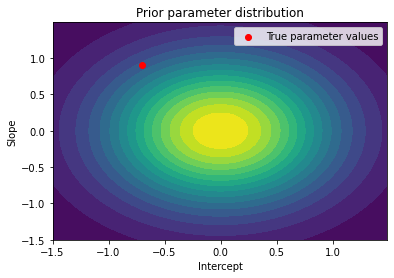

In [ ]:
# Initialize BLR model
prior_mean = np.array([0, 0])
prior_cov = 1/2 * np.identity(2)
blr = BayesianLinearRegression(prior_mean, prior_cov, noise_var)

def plot_param_posterior(lower_bound, upper_bound, blr, title):
    fig = plt.figure()
    mesh_features, mesh_labels = np.mgrid[lower_bound:upper_bound:.01, lower_bound:upper_bound:.01]
    pos = np.dstack((mesh_features, mesh_labels))
    plt.contourf(mesh_features, mesh_labels, blr.param_posterior.pdf(pos), levels=15)
    plt.scatter(intercept, slope, color='red', label="True parameter values")
    plt.title(title)
    plt.xlabel("Intercept")
    plt.ylabel("Slope")
    plt.legend();
    
# Visualize parameter prior distribution
plot_param_posterior(lower_bound, upper_bound, blr, title="Prior parameter distribution")

### **5.Posterior predictive distribution  <a class="anchor" id="predictive-posterior"></a>**
 
Let's add a `predict` method to our `BayesianLinearRegression` class which computes the predictive posterior for a new input (you will find the method in the class definition above):

In [ ]:
def predict(self, features: np.ndarray):
    """
    Compute predictive posterior given new datapoint

    Args:
        features: 1d numpy array of features
    Returns:
        pred_posterior: predictive posterior distribution
    """
    design_matrix = self.compute_design_matrix(features)

    pred_mean = design_matrix.dot(self.post_mean)
    pred_cov = design_matrix.dot(self.post_cov.dot(design_matrix.T)) + self.noise_var

    pred_posterior = univariate_normal(pred_mean.flatten(), pred_cov)
    return pred_posterior